# WIC

The [Special Supplemental Nutrition Program for Women, Infants, and Children (WIC)](https://www.fns.usda.gov/wic) provides vouchers for food and formula to low-income mothers and children deemed to be at nutritional risk.
The [Food and Nutrition Service (FNS)](https://www.fns.usda.gov), a division of the [United States Department of Agriculture (USDA)](https://usda.gov), administers WIC.

## Examples

### How WIC values depend on income

Consider a pregnant woman in Oregon whose husband has no income, and whom a WIC office has deemed to be at nutritional risk.

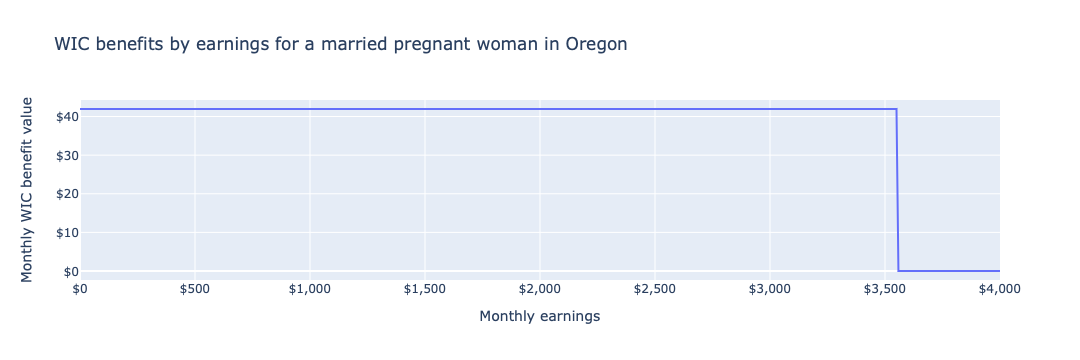

In [27]:
from policyengine_us import IndividualSim
import numpy as np
import pandas as pd
import plotly.express as px

sim = IndividualSim(year=2022)
sim.add_person(
    name="mother",
    is_pregnant=True,
    is_wic_at_nutritional_risk=True,
    would_claim_wic=True,
)
sim.add_person(name="father")
sim.add_spm_unit(members=["mother", "father"])
sim.add_household(members=["mother", "father"], state_code="OR")

sim.vary("employment_income", max=4_000 * 12)

df = pd.DataFrame(
    dict(
        employment_income=sim.calc("employment_income")[0] / 12,
        wic=sim.calc("wic")[0] / 12,
    )
)


LABELS = dict(
    age="Child age",
    is_breastfeeding="Breastfeeding",
    wic="Monthly WIC benefit value",
    employment_income="Monthly earnings",
)

fig = px.line(
    df,
    "employment_income",
    "wic",
    labels=LABELS,
    title="WIC benefits by earnings for a married pregnant woman in Oregon",
)
fig.update_layout(xaxis_tickformat="$,", yaxis_tickformat="$,")
fig.show()

### How WIC values depend on breastfeeding status

Consider a single mother with \$2,000 monthly income and one child.
A WIC office has deemed both to be at nutritional risk.
They will receive WIC vouchers until the child reaches age five, though their benefit will vary with the child's age and whether the mother breastfeeds.

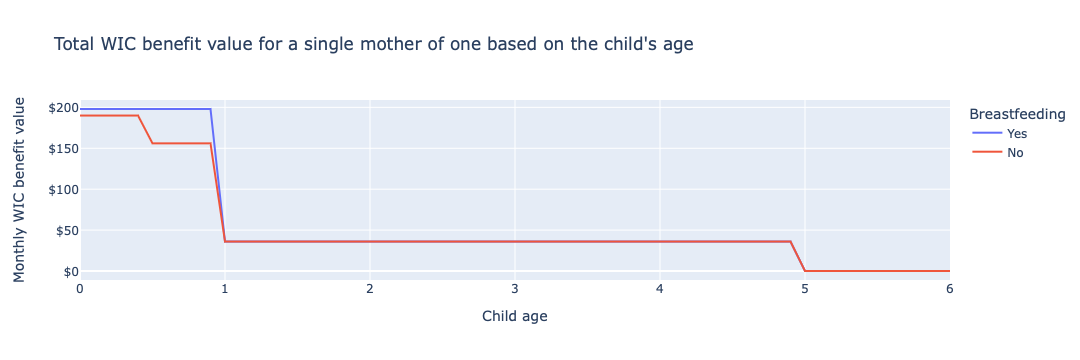

In [29]:
def wic_by_child_age(is_breastfeeding):
    sim = IndividualSim(year=2022)
    sim.add_person(name="child", is_wic_at_nutritional_risk=True)
    sim.add_person(
        name="mother",
        employment_income=2_000 * 12,
        # is_mother defaults to is_breastfeeding, but we need to set it
        # explicitly for non-breastfeeding mothers.
        is_mother=True,
        is_breastfeeding=is_breastfeeding,
        is_wic_at_nutritional_risk=True,
    )
    sim.add_family(members=["mother", "child"])
    sim.add_spm_unit(members=["mother", "child"])

    sim.vary("age", max=6, step=0.1)

    return pd.DataFrame(
        dict(
            is_breastfeeding=np.where(is_breastfeeding, "Yes", "No"),
            age=sim.calc("age")[0],
            wic=(sim.calc("wic").sum(axis=0) / 12).round(),
        )
    )


df = pd.concat([wic_by_child_age(True), wic_by_child_age(False)])

fig = px.line(
    df,
    "age",
    "wic",
    color="is_breastfeeding",
    labels=LABELS,
    title="Total WIC benefit value for a single mother of one based on the child's age",
)
fig.update_layout(yaxis_tickformat="$,")
fig.show()